In [ ]:
from pathlib import Path
import json
import pandas as pd
import numpy as np
import re
import ast
import pandas as pd

In [ ]:
df = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/cluster-questions/math_questions.csv", quotechar='"', skipinitialspace=True, on_bad_lines='skip')
print(f"Loaded {len(df)} questions.")

In [ ]:
df_with_id = df.reset_index().rename(columns={"index": "question_id"})
df_with_id.to_csv("math_questions_with_id.csv", index=False)

In [8]:
df_with_id.head()

,question_id,question
0,0,\nA natural number \( N \) is represented as \...
1,1,\nFind the derivative.\n\n$$\ny=\frac{2}{3}\le...
2,2,"\nGrandpa is twice as strong as Grandma, Grand..."
3,3,"\nIn a city, there are 10 parallel streets run..."
4,4,\nLet $\mathrm{ABC}$ be a triangle where the a...


In [ ]:
# df_with_id.head(100).to_csv("math_sample.csv", index=False)

# What kinds of questions benefit from what kinds of decoding strategies?

In [ ]:
# finding compute max-utility pred.

In [15]:
def compute_max_utility_pred(df, lambda_, method="oracle", costa="token_count", costb="time", fixed_lambda=0):
    def get_max_utility(group):
        group = group.copy()
        if method == "oracle":
            group["utility"] = group["sl"] - lambda_ * group[costa] - fixed_lambda * group[costb]
        elif method == "adaptive_router":
            group["utility"] = group["calibrated_probs"] - lambda_ * group[costa] - fixed_lambda * group[costb]
        else:
            raise ValueError(f"Invalid method: {method}")
        idx_max = group["utility"].idxmax()

        return pd.Series({
            "max_utility": group.loc[idx_max, "utility"],
            "max_predicted_prob": group.loc[idx_max, "calibrated_probs"],
            "max_sl": group.loc[idx_max, "sl"],
            "max_cost": group.loc[idx_max, "token_count"],
            "max_time": group.loc[idx_max, "time"],
            "N": group.loc[idx_max, "N"],
            "beam_width": group.loc[idx_max, "beam_width"],
            "max_iteration": group.loc[idx_max, "max_iteration"],
            "method": group.loc[idx_max, "method"] # sept 3rd. added method.
        })

    result_df = df.groupby("question").apply(get_max_utility).reset_index()
    return result_df

In [16]:
df_test = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon_beam_test_df.csv")

In [17]:
ys = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-model/bon-beam-model/true_labels.npy")
calibrated_probs = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/bon-beam-model/bon-beam-model/calibrated_probs.npy")
# ys = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/BERT-model/BERT-model/true_labels.npy")
# calibrated_probs = np.load("/dccstor/gma2/mehuldamani/search-and-learn/aug24/BERT-model/BERT-model/calibrated_probs.npy")

print(calibrated_probs.shape, calibrated_probs.min().item(), calibrated_probs.max().item())
print(ys.shape, ys.min().item(), ys.max().item())

ys.shape, calibrated_probs.shape

(22206,) 2.209193553426303e-05 0.9999314546585083
(22206,) 0.0 1.0


((22206,), (22206,))

In [18]:
df_test['calibrated_probs'] = calibrated_probs

In [19]:
# continued from router-predcosts.ipynb
hybrid_router = compute_max_utility_pred(df_test, lambda_=1e-5, method="oracle", costa="token_count", costb="time", fixed_lambda=1e-2)

/tmp/ipykernel_4006933/3274000803.py:24: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result_df = df.groupby("question").apply(get_max_utility).reset_index()


In [20]:
hybrid_router.head()

,question,max_utility,max_predicted_prob,max_sl,max_cost,max_time,N,beam_width,max_iteration,method
0,\nA natural number \( N \) is represented as \...,-0.06431,0.029400,0.0,1461,4.97,2.0,0.0,0.0,majority
1,\nFind the derivative.\n\n$$\ny=\frac{2}{3}\le...,-0.13120,0.015579,0.0,3440,9.68,2.0,0.0,0.0,majority
2,"\nGrandpa is twice as strong as Grandma, Grand...",-0.05115,0.169162,0.0,2495,2.62,4.0,0.0,0.0,majority
3,"\nIn a city, there are 10 parallel streets run...",-0.03305,0.150315,0.0,1135,2.17,2.0,0.0,0.0,majority
4,\nLet $\mathrm{ABC}$ be a triangle where the a...,-0.06382,0.010294,0.0,1342,5.04,2.0,2.0,40.0,beam_search


# Join routing results with problem categories.

In [22]:
math_questions_classified = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/math_questions_classified_final.csv")

In [23]:
math_questions_classified.head()

,question_id,question,subdomain,format
0,0,\nA natural number \( N \) is represented as \...,Number Theory,Proof-Style
1,1,\nFind the derivative.\n\n$$\ny=\frac{2}{3}\le...,Calculus / Analysis,Symbolic Manipulation
2,2,"\nGrandpa is twice as strong as Grandma, Grand...",Algebra,Word Problem
3,3,"\nIn a city, there are 10 parallel streets run...",Counting & Combinatorics,Proof-Style
4,4,\nLet $\mathrm{ABC}$ be a triangle where the a...,Geometry,Geometry Construction / Diagram


In [24]:
# Join math_questions_classified with hybrid_router on the question text
routing_decisions = pd.merge(
    hybrid_router,
    math_questions_classified,
    how="left",
    left_on="question",
    right_on="question"
)
routing_decisions.head()

,question,max_utility,max_predicted_prob,max_sl,max_cost,max_time,N,beam_width,max_iteration,method,question_id,subdomain,format
0,\nA natural number \( N \) is represented as \...,-0.06431,0.029400,0.0,1461,4.97,2.0,0.0,0.0,majority,0,Number Theory,Proof-Style
1,\nFind the derivative.\n\n$$\ny=\frac{2}{3}\le...,-0.13120,0.015579,0.0,3440,9.68,2.0,0.0,0.0,majority,1,Calculus / Analysis,Symbolic Manipulation
2,"\nGrandpa is twice as strong as Grandma, Grand...",-0.05115,0.169162,0.0,2495,2.62,4.0,0.0,0.0,majority,2,Algebra,Word Problem
3,"\nIn a city, there are 10 parallel streets run...",-0.03305,0.150315,0.0,1135,2.17,2.0,0.0,0.0,majority,3,Counting & Combinatorics,Proof-Style
4,\nLet $\mathrm{ABC}$ be a triangle where the a...,-0.06382,0.010294,0.0,1342,5.04,2.0,2.0,40.0,beam_search,4,Geometry,Geometry Construction / Diagram


In [25]:
# routing_decisions.to_csv("/dccstor/gma2/mehuldamani/search-and-learn/cluster-questions/math_routing_decisions.csv", index=False)
routing_decisions = pd.read_csv("/dccstor/gma2/mehuldamani/search-and-learn/cluster-questions/math_routing_decisions.csv")

In [26]:
# Create a new column 'subdomain_collapsed' that collapses subdomains as specified
def collapse_subdomain(subdomain):
    if isinstance(subdomain, str):
        if subdomain.startswith("Algebra"):
            return "Algebra"
        elif subdomain.startswith("Geometry"):
            return "Geometry"
        elif subdomain.startswith("Number Theory"):
            return "Number Theory"
    return subdomain

routing_decisions['subdomain'] = routing_decisions['subdomain'].apply(collapse_subdomain)
routing_decisions

,question,max_utility,max_predicted_prob,max_sl,max_cost,max_time,N,beam_width,max_iteration,method,question_id,subdomain,format
0,\nA natural number \( N \) is represented as \...,-0.064310,0.029400,0.000000,1461,4.97,2.0,0.0,0.0,majority,0,Number Theory,Proof-Style
1,\nFind the derivative.\n\n$$\ny=\frac{2}{3}\le...,-0.131200,0.015579,0.000000,3440,9.68,2.0,0.0,0.0,majority,1,Calculus / Analysis,Symbolic Manipulation
2,"\nGrandpa is twice as strong as Grandma, Grand...",-0.051150,0.169162,0.000000,2495,2.62,4.0,0.0,0.0,majority,2,Algebra,Word Problem
3,"\nIn a city, there are 10 parallel streets run...",-0.033050,0.150315,0.000000,1135,2.17,2.0,0.0,0.0,majority,3,Counting & Combinatorics,Proof-Style
4,\nLet $\mathrm{ABC}$ be a triangle where the a...,-0.063820,0.010294,0.000000,1342,5.04,2.0,2.0,40.0,beam_search,4,Geometry,Geometry Construction / Diagram
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1786,two pipes p and q can fill a cistern in 10 and...,0.952500,0.805934,1.000000,940,3.81,2.0,2.0,40.0,beam_search,1786,Algebra,Word Problem
1787,two trains 170 m and 160 m long run at the spe...,0.436620,0.224583,0.500000,3398,2.94,8.0,0.0,0.0,naive,1787,Algebra,Word Problem
1788,workers at a campaign office have 2500 fliers ...,0.902907,0.974810,0.966667,2366,4.01,8.0,4.0,20.0,beam_search,1788,Algebra,Word Problem
1789,you have 59 cubic blocks . what is the minimum...,0.626590,0.212485,0.700000,4051,3.29,16.0,0.0,0.0,naive,1789,Number Theory,Word Problem


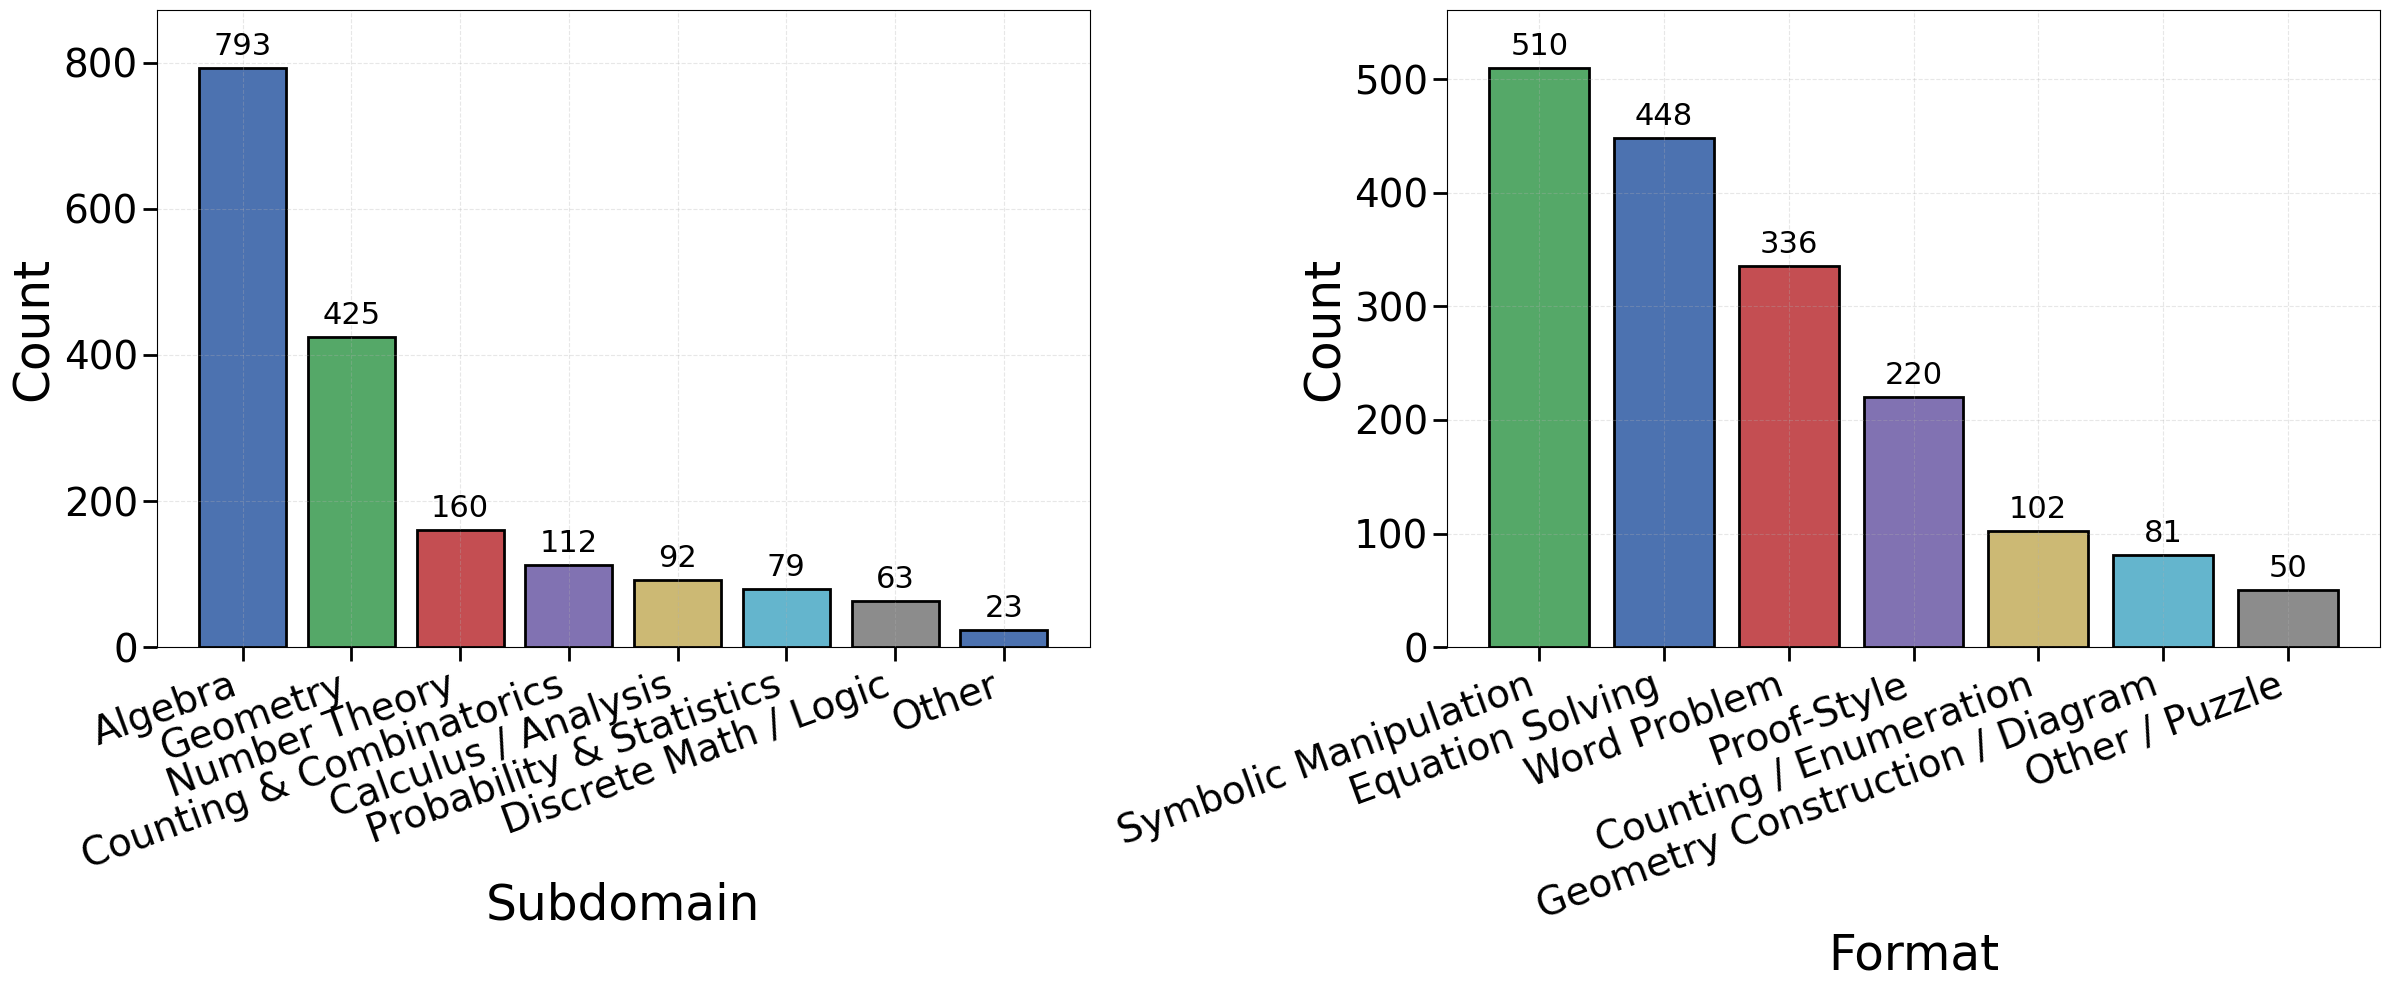

In [37]:
import matplotlib.pyplot as plt

# Set font sizes to match the referenced figure
label_fontsize = 35
tick_fontsize = 28
title_fontsize = 35
annot_fontsize = 22
legend_fontsize = 25

# Custom color palette for consistency and clarity
subdomain_colors = [
    "#4C72B0", "#55A868", "#C44E52", "#8172B2", "#CCB974", "#64B5CD", "#8C8C8C"
]
format_colors = [
    "#55A868", "#4C72B0", "#C44E52", "#8172B2", "#CCB974", "#64B5CD", "#8C8C8C"
]

# --- Subdomain and Format Distributions Side-by-Side ---
subdomain_counts = routing_decisions['subdomain'].value_counts()
subdomain_labels = subdomain_counts.index.tolist()
subdomain_values = subdomain_counts.values

format_counts = routing_decisions['format'].value_counts()
format_labels = format_counts.index.tolist()
format_values = format_counts.values

fig, axes = plt.subplots(1, 2, figsize=(24, 10))

# --- Subdomain Distribution ---
ax = axes[0]
bars = ax.bar(
    range(len(subdomain_labels)),
    subdomain_values,
    color=subdomain_colors[:len(subdomain_labels)],
    edgecolor='black',
    linewidth=2
)
ax.set_xlabel('Subdomain', fontsize=label_fontsize)
ax.set_ylabel('Count', fontsize=label_fontsize)
ax.set_xticks(range(len(subdomain_labels)))
ax.set_xticklabels(subdomain_labels, fontsize=tick_fontsize, rotation=20, ha="right")
ax.set_ylim(0, max(subdomain_values) * 1.10)
# ax.set_title('Distribution of Subdomain', fontsize=title_fontsize, pad=20)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, length=10, width=2)
ax.tick_params(axis='both', which='minor', labelsize=20, length=6, width=1.5)
ax.grid(True, which='both', linestyle='--', alpha=0.3)
for bar, value in zip(bars, subdomain_values):
    ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=annot_fontsize)

# --- Format Distribution ---
ax = axes[1]
bars = ax.bar(
    range(len(format_labels)),
    format_values,
    color=format_colors[:len(format_labels)],
    edgecolor='black',
    linewidth=2
)
ax.set_xlabel('Format', fontsize=label_fontsize)
ax.set_ylabel('Count', fontsize=label_fontsize)
ax.set_xticks(range(len(format_labels)))
ax.set_xticklabels(format_labels, fontsize=tick_fontsize, rotation=20, ha="right")
ax.set_ylim(0, max(format_values) * 1.10)
# ax.set_title('Distribution of Format', fontsize=title_fontsize, pad=20)
ax.tick_params(axis='both', which='major', labelsize=tick_fontsize, length=10, width=2)
ax.tick_params(axis='both', which='minor', labelsize=20, length=6, width=1.5)
ax.grid(True, which='both', linestyle='--', alpha=0.3)
for bar, value in zip(bars, format_values):
    ax.annotate(f"{value}", xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=annot_fontsize)

plt.tight_layout()
plt.show()

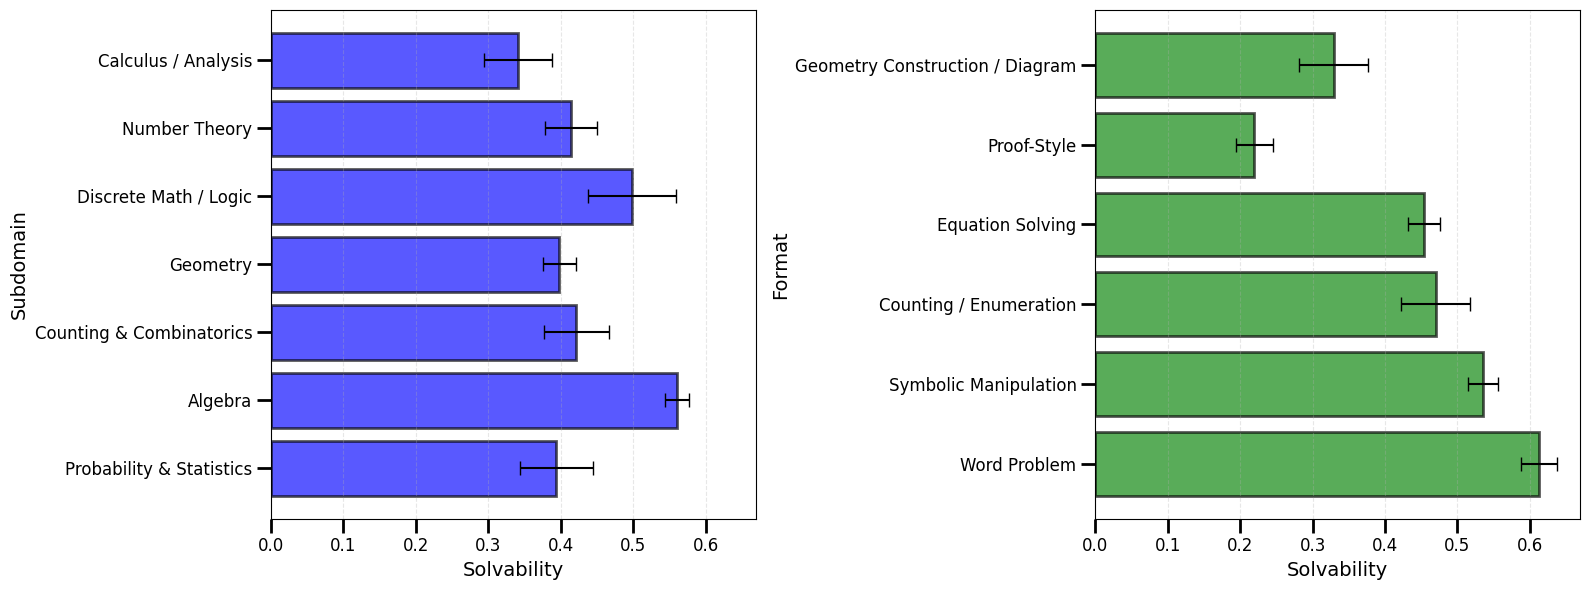

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Compute mean and standard error of max_sl for subdomain and format
subdomain_acc = routing_decisions.groupby('subdomain').agg(
    mean_max_sl=('max_sl', 'mean'),
    se_max_sl=('max_sl', lambda x: x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0)
).reset_index()

format_acc = routing_decisions.groupby('format').agg(
    mean_max_sl=('max_sl', 'mean'),
    se_max_sl=('max_sl', lambda x: x.std(ddof=1) / np.sqrt(len(x)) if len(x) > 1 else 0)
).reset_index()

# Remove "Other" if present
subdomain_acc = subdomain_acc[subdomain_acc['subdomain'] != 'Other']
format_acc = format_acc[(format_acc['format'] != 'Other') & (format_acc['format'] != 'Other / Puzzle')]

# Define desired subdomain and format orders (top to bottom, reversed)
subdomain_order = [
    'Probability & Statistics',
    'Algebra',
    'Counting & Combinatorics',
    'Geometry',
    'Discrete Math / Logic',
    'Number Theory',
    'Calculus / Analysis'
]
format_order = [
    'Word Problem',
    'Symbolic Manipulation',
    'Counting / Enumeration',
    'Equation Solving',
    'Proof-Style',
    'Geometry Construction / Diagram'
    # 'Other / Puzzle' removed
]

# Use the desired order from context, and filter to only those present
subdomain_order_present = [s for s in subdomain_order if s in set(subdomain_acc['subdomain'])]
format_order_present = [f for f in format_order if f in set(format_acc['format'])]

subdomain_acc['subdomain'] = pd.Categorical(subdomain_acc['subdomain'], categories=subdomain_order_present, ordered=True)
format_acc['format'] = pd.Categorical(format_acc['format'], categories=format_order_present, ordered=True)

subdomain_acc = subdomain_acc.sort_values('subdomain')
format_acc = format_acc.sort_values('format')

# Set left plot to blue, right plot to green, and make bars more transparent
subdomain_color = 'blue'
format_color = 'green'
bar_alpha = 0.65  # More transparent

# Plot side-by-side horizontal barplot
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharex=True)

# Subdomain horizontal barplot (left, blue, transparent)
bars0 = axes[0].barh(
    subdomain_acc['subdomain'],
    subdomain_acc['mean_max_sl'],
    xerr=subdomain_acc['se_max_sl'],
    capsize=5,
    color=subdomain_color,
    edgecolor='black',
    linewidth=2,
    alpha=bar_alpha
)
axes[0].set_yticks(range(len(subdomain_acc)))
axes[0].set_yticklabels(subdomain_acc['subdomain'], fontsize=12)
axes[0].set_ylabel('Subdomain', fontsize=14)
axes[0].set_xlabel('Solvability', fontsize=14)
axes[0].tick_params(axis='both', which='major', labelsize=12, length=10, width=2)
axes[0].tick_params(axis='both', which='minor', labelsize=10, length=6, width=1.5)
axes[0].grid(True, which='both', axis='x', linestyle='--', alpha=0.3)
# for bar, value in zip(bars0, subdomain_acc['mean_max_sl']):
#     axes[0].annotate(f"{value:.2f}", xy=(value, bar.get_y() + bar.get_height() / 2),
#                      xytext=(5, 0), textcoords="offset points", va='center', ha='left', fontsize=11)

# Format horizontal barplot (right, green, transparent)
bars1 = axes[1].barh(
    format_acc['format'],
    format_acc['mean_max_sl'],
    xerr=format_acc['se_max_sl'],
    capsize=5,
    color=format_color,
    edgecolor='black',
    linewidth=2,
    alpha=bar_alpha
)
axes[1].set_yticks(range(len(format_acc)))
axes[1].set_yticklabels(format_acc['format'], fontsize=12)
axes[1].set_ylabel('Format', fontsize=14)
axes[1].set_xlabel('Solvability', fontsize=14)
axes[1].tick_params(axis='both', which='major', labelsize=12, length=10, width=2)
axes[1].tick_params(axis='both', which='minor', labelsize=10, length=6, width=1.5)
axes[1].grid(True, which='both', axis='x', linestyle='--', alpha=0.3)


plt.tight_layout()
plt.show()

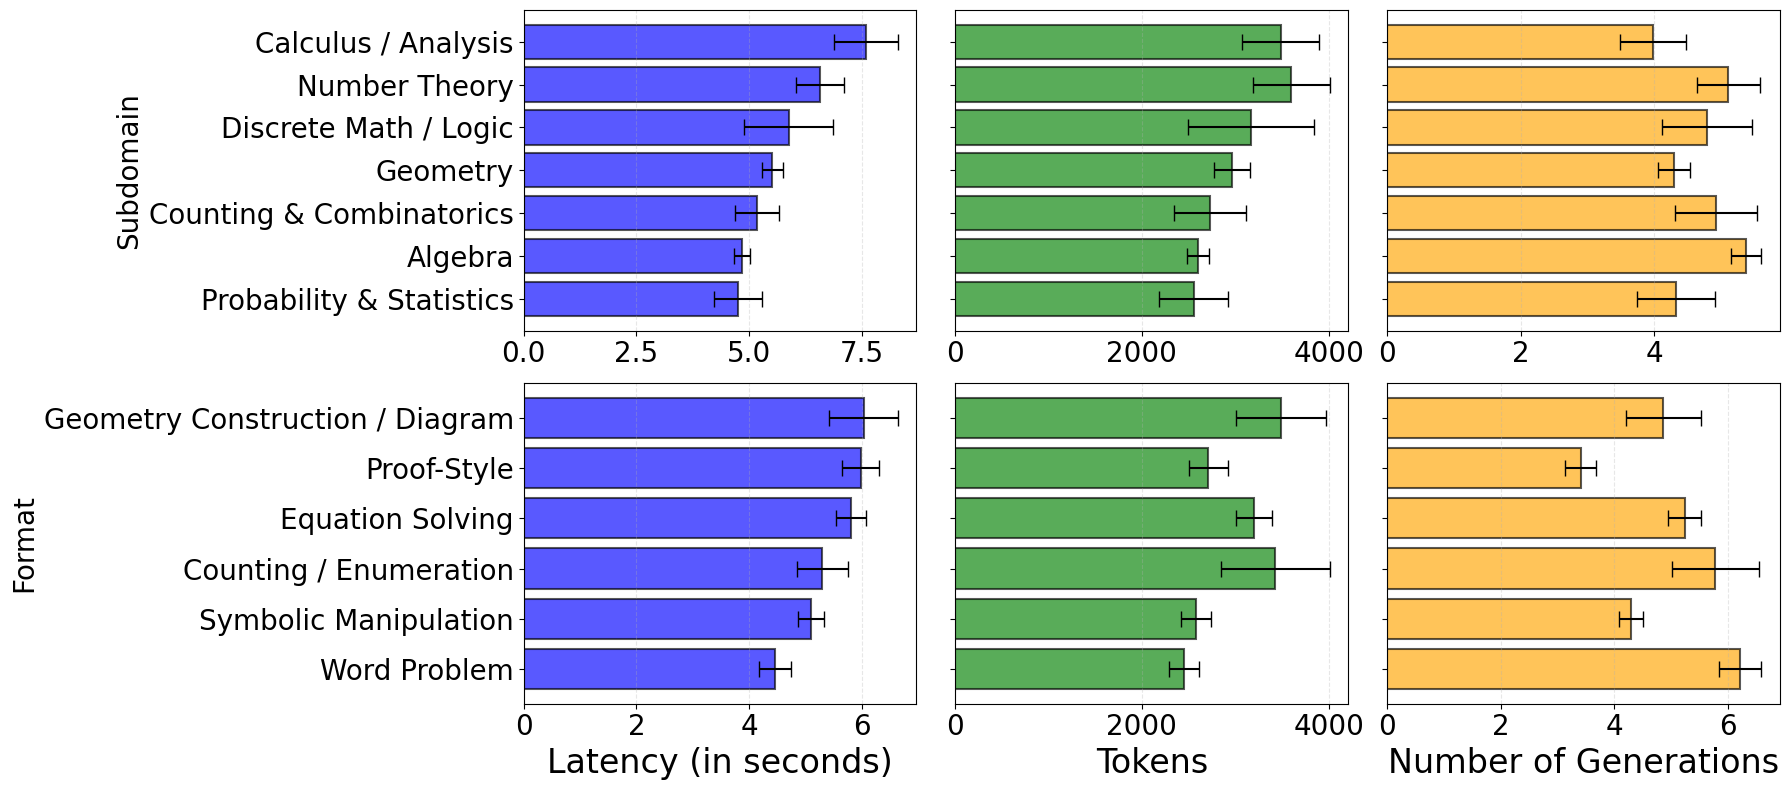

In [19]:
# Remove "Other" subdomain if present
filtered_agg_df = routing_decisions[routing_decisions['subdomain'] != 'Other'].groupby('subdomain').agg(
    avg_max_cost=('max_cost', 'mean'),
    se_max_cost=('max_cost', lambda x: x.std(ddof=1) / (len(x)**0.5) if len(x) > 1 else 0),
    avg_max_time=('max_time', 'mean'),
    se_max_time=('max_time', lambda x: x.std(ddof=1) / (len(x)**0.5) if len(x) > 1 else 0),
    avg_N=('N', 'mean'),
    se_N=('N', lambda x: x.std(ddof=1) / (len(x)**0.5) if len(x) > 1 else 0)
).reset_index()

# Remove "Other / Puzzle" format if present
filtered_agg_df_format = routing_decisions[
    (routing_decisions['format'] != 'Other') & (routing_decisions['format'] != 'Other / Puzzle')
].groupby('format').agg(
    avg_max_cost=('max_cost', 'mean'),
    se_max_cost=('max_cost', lambda x: x.std(ddof=1) / (len(x)**0.5) if len(x) > 1 else 0),
    avg_max_time=('max_time', 'mean'),
    se_max_time=('max_time', lambda x: x.std(ddof=1) / (len(x)**0.5) if len(x) > 1 else 0),
    avg_N=('N', 'mean'),
    se_N=('N', lambda x: x.std(ddof=1) / (len(x)**0.5) if len(x) > 1 else 0)
).reset_index()

# Reorder metrics so that latency is the leftmost plot
metrics = [
    ('avg_max_time', 'se_max_time', 'Latency (in seconds)'),
    ('avg_max_cost', 'se_max_cost', 'Tokens'),
    ('avg_N', 'se_N', 'Number of Generations')
]
metrics_format = [
    ('avg_max_time', 'se_max_time', 'Latency (in seconds)'),
    ('avg_max_cost', 'se_max_cost', 'Tokens'),
    ('avg_N', 'se_N', 'Number of Generations')
]
color_palette = ['blue', 'green', 'orange']
alpha_val = 0.65  # Set transparency

# Sort the dataframes by latency (avg_max_time) in increasing order for all plots
sorted_df = filtered_agg_df.sort_values(by='avg_max_time', ascending=True)
sorted_df_format = filtered_agg_df_format.sort_values(by='avg_max_time', ascending=True)

# Create a 2-row, 3-column grid of subplots (top: subdomain, bottom: format)
fig, axes = plt.subplots(2, 3, figsize=(18, max(8, 1.0*max(len(sorted_df), len(sorted_df_format)))), sharey=False)

 # Top row: subdomain
for i, (mean_col, se_col, label) in enumerate(metrics):
    ax = axes[0, i]
    ax.barh(
        sorted_df['subdomain'],
        sorted_df[mean_col],
        xerr=sorted_df[se_col],
        color=color_palette[i],
        edgecolor='black',
        linewidth=1.5,
        capsize=6,
        alpha=alpha_val
    )
    # Only show y-axis label for the first subplot in the row
    if i == 0:
        ax.set_ylabel('Subdomain', fontsize=20)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    # Do NOT show x-axis label for the top row
    # ax.set_xlabel(label, fontsize=24)
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    # ax.set_title(label, fontsize=15, pad=12)

# Bottom row: format
for i, (mean_col, se_col, label) in enumerate(metrics_format):
    ax = axes[1, i]
    ax.barh(
        sorted_df_format['format'],
        sorted_df_format[mean_col],
        xerr=sorted_df_format[se_col],
        color=color_palette[i],
        edgecolor='black',
        linewidth=1.5,
        capsize=6,
        alpha=alpha_val
    )
    ax.set_xlabel(label, fontsize=24)
    # Only show y-axis label for the first subplot in the row
    if i == 0:
        ax.set_ylabel('Format', fontsize=20)
    else:
        ax.set_ylabel('')
        ax.set_yticklabels([])
    ax.tick_params(axis='y', labelsize=20)
    ax.tick_params(axis='x', labelsize=20)
    ax.grid(True, axis='x', linestyle='--', alpha=0.3)
    # ax.set_title(label, fontsize=15, pad=12)

plt.tight_layout()
plt.show()

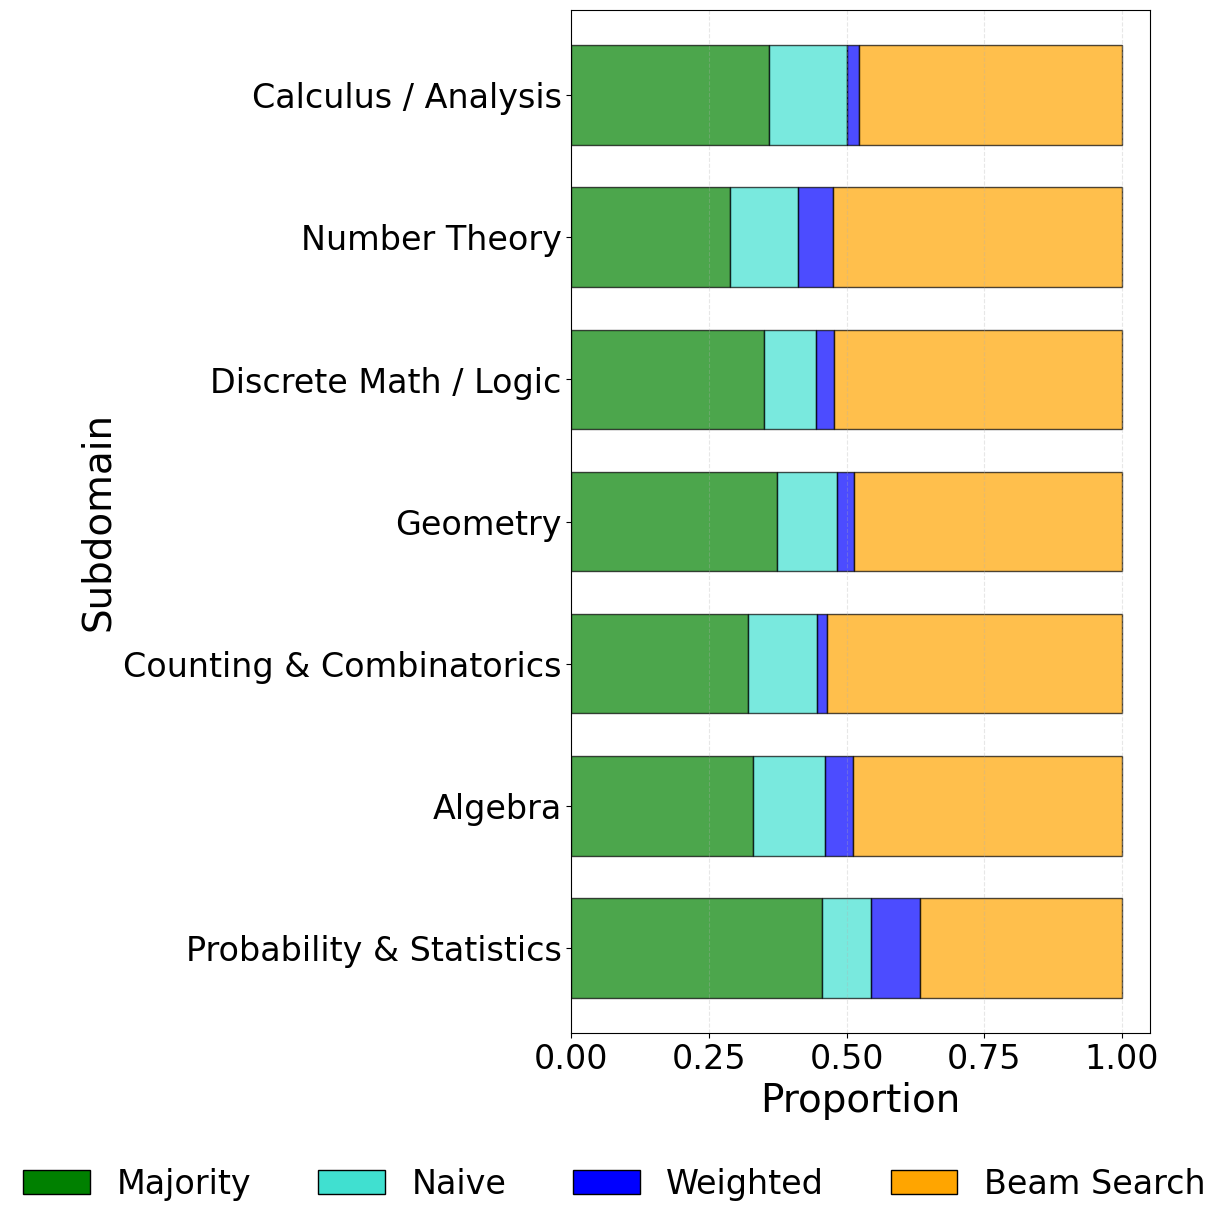

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

# Define the method order and color mapping (no 'other')
method_order = ['majority', 'naive', 'weighted', 'beam_search']
method_color_map = {
    'majority': 'green',
    'naive': 'turquoise',
    'weighted': 'blue',
    'beam_search': 'orange',
}
method_palette = [method_color_map[m] for m in method_order]

# Define desired subdomain order (top to bottom, reversed)
subdomain_order = [
    'Probability & Statistics',
    'Algebra',
    'Counting & Combinatorics',
    'Geometry',
    'Discrete Math / Logic',
    'Number Theory',
    'Calculus / Analysis'
]

# Prepare data for plotting: method breakdown by subdomain
method_subdomain = routing_decisions.groupby(['subdomain', 'method']).size().unstack(fill_value=0)
# Remove 'other' if present in methods
if 'other' in method_subdomain.columns:
    method_subdomain = method_subdomain.drop(columns=['other'])
# Restrict to only the subdomains in the specified order and drop others
method_subdomain = method_subdomain.loc[
    [sd for sd in subdomain_order if sd in method_subdomain.index]
]
# Reindex columns to match order
method_subdomain = method_subdomain.reindex(columns=method_order, fill_value=0)
method_subdomain_prop = method_subdomain.div(method_subdomain.sum(axis=1), axis=0)  # Proportions

# Create a single plot for subdomain
fig, ax = plt.subplots(
    1, 1, 
    figsize=(11, 12)
)

# Plot: Method breakdown by subdomain (stacked bar)
method_subdomain_prop.plot(
    kind='barh',
    stacked=True,
    ax=ax,
    color=method_palette,
    edgecolor='black',
    width=0.7,
    alpha=0.70,
    legend=False  # Remove legend from the plot
)
ax.set_xlabel("Proportion", fontsize=28)
ax.set_ylabel("Subdomain", fontsize=28)
ax.tick_params(axis='y', labelsize=24)
ax.tick_params(axis='x', labelsize=24)
ax.grid(axis='x', linestyle='--', alpha=0.3)
ax.set_title("", fontsize=24)

# Add the legend below the figure
legend_handles = [Patch(facecolor=method_color_map[m], edgecolor='black', label=m.replace('_', ' ').title()) for m in method_order]
fig.legend(
    handles=legend_handles,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.03),
    ncol=len(method_order),
    fontsize=24,
    frameon=False
)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()

Next, we will add in latency.

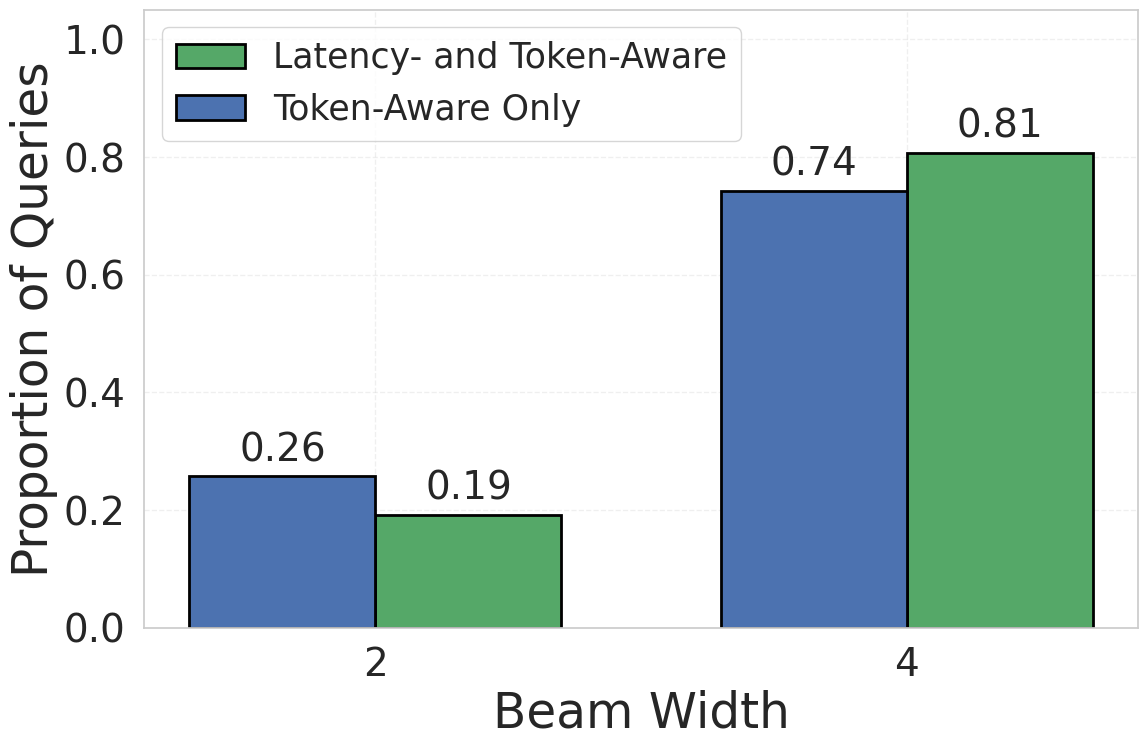

In [ ]:
# Get proportions for beam_width 2 and 4 in both routers
def get_beam_width_props(df):
    counts = df['beam_width'].value_counts(normalize=True)
    return [counts.get(2.0, 0), counts.get(4.0, 0)]

tc_props = get_beam_width_props(beam_tc_router_n16)
hybrid_props = get_beam_width_props(beam_hybrid_router_n16)
beam_width_labels = ['2', '4']
x = np.arange(len(beam_width_labels))
width = 0.35

# create plot.
fig, ax = plt.subplots(figsize=(12, 8))
rects1 = ax.bar(x + width/2, hybrid_props, width, label='Latency- and Token-Aware', color='#55A868', edgecolor='black', linewidth=2)
rects2 = ax.bar(x - width/2, tc_props, width, label='Token-Aware Only', color='#4C72B0', edgecolor='black', linewidth=2)

ax.set_xlabel('Beam Width', fontsize=35)
ax.set_ylabel('Proportion of Queries', fontsize=35)
ax.set_xticks(x)
ax.set_xticklabels(beam_width_labels, fontsize=28)
ax.set_ylim(0, 1.05)
# ax.set_title('Beam Width Decisions', fontsize=20)
ax.legend(fontsize=25, title_fontsize=25)
ax.tick_params(axis='both', which='major', labelsize=28, length=10, width=2)
ax.tick_params(axis='both', which='minor', labelsize=20, length=6, width=1.5)
ax.grid(True, which='both', linestyle='--', alpha=0.3)

# Annotate bars with values
for bars, props in zip([rects1, rects2], [hybrid_props, tc_props]):
    for bar, prop in zip(bars, props):
        ax.annotate(f"{prop:.2f}", xy=(bar.get_x() + bar.get_width() / 2, bar.get_height()),
                    xytext=(0, 5), textcoords="offset points", ha='center', va='bottom', fontsize=28)

plt.tight_layout()
plt.show()

